In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
data = pd.read_csv("full_df.csv")
df = pd.DataFrame(data)
df.head(5)

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Trying to do perform predictions without the image first, later we use the images and do a prediction, we compare how much impact the images have on the prediction.

In [4]:
print(list(df.columns))

['ID', 'Patient Age', 'Patient Sex', 'Fundus', 'Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename']


In [5]:
df = df.drop(columns=['Fundus','filepath','filename','target'])

In [6]:
df.head(5)

,ID,Patient Age,Patient Sex,Diagnostic Keywords,N,D,G,C,A,H,M,O,labels
0,0,69,Female,normal fundus,0,0,0,1,0,0,0,0,['N']
1,1,57,Male,normal fundus,1,0,0,0,0,0,0,0,['N']
2,2,42,Male,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,['D']
3,4,53,Male,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,['D']
4,5,50,Female,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,['D']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   3194 non-null   int64 
 1   Patient Age          3194 non-null   int64 
 2   Patient Sex          3194 non-null   object
 3   Diagnostic Keywords  3194 non-null   object
 4   N                    3194 non-null   int64 
 5   D                    3194 non-null   int64 
 6   G                    3194 non-null   int64 
 7   C                    3194 non-null   int64 
 8   A                    3194 non-null   int64 
 9   H                    3194 non-null   int64 
 10  M                    3194 non-null   int64 
 11  O                    3194 non-null   int64 
 12  labels               3194 non-null   object
dtypes: int64(10), object(3)
memory usage: 324.5+ KB


In [8]:
# we can observe that there are no null values present in the dataset
# we can now convert the categorical data into numerical data

gender_mapping = {'Male': 0, 'Female': 1}
df['Patient Sex'] = df['Patient Sex'].map(gender_mapping)

In [9]:
df.head(5)

,ID,Patient Age,Patient Sex,Diagnostic Keywords,N,D,G,C,A,H,M,O,labels
0,0,69,1,normal fundus,0,0,0,1,0,0,0,0,['N']
1,1,57,0,normal fundus,1,0,0,0,0,0,0,0,['N']
2,2,42,0,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,['D']
3,4,53,0,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,['D']
4,5,50,1,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,['D']


In [10]:
df['Diagnostic Keywords'].nunique()

148

In [11]:
# enumerating the unique values of the text data in both the columns
unique_values = df['Diagnostic Keywords'].unique()
value_to_number = {value: number for number, value in enumerate(unique_values, start=1)}
df['Diagnostic Keywords'] = df['Diagnostic Keywords'].replace(value_to_number)


In [12]:
df['Patient Age'].nunique()  # number of unique values in Patient Age column

75

In [13]:
print(df['N'].nunique())  # number of unique values in N column
print(df['D'].nunique())  # number of unique values in D column
print(df['G'].nunique())  # number of unique values in G column
print(df['C'].nunique())  # number of unique values in C column
print(df['A'].nunique())  # number of unique values in A column
print(df['H'].nunique())  # number of unique values in H column
print(df['M'].nunique())  # number of unique values in M column
print(df['O'].nunique())  # number of unique values in 0 column

2
2
2
2
2
2
2
2


In [14]:
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [15]:
df.head(5)

,ID,Patient Age,Patient Sex,Diagnostic Keywords,N,D,G,C,A,H,M,O,labels
0,0,69,1,1,0,0,0,1,0,0,0,0,6
1,1,57,0,1,1,0,0,0,0,0,0,0,6
2,2,42,0,2,0,1,0,0,0,0,0,1,2
3,4,53,0,3,0,1,0,0,0,0,0,1,2
4,5,50,1,2,0,1,0,0,0,0,0,0,2


In [48]:
y = df['labels']
X = df.drop(columns=['ID', 'labels'])

In [17]:
X.head(5)

,Patient Age,Patient Sex,Diagnostic Keywords,N,D,G,C,A,H,M,O
0,69,1,1,0,0,0,1,0,0,0,0
1,57,0,1,1,0,0,0,0,0,0,0
2,42,0,2,0,1,0,0,0,0,0,1
3,53,0,3,0,1,0,0,0,0,0,1
4,50,1,2,0,1,0,0,0,0,0,0


In [18]:
y.head(5)

0    6
1    6
2    2
3    2
4    2
Name: labels, dtype: int64

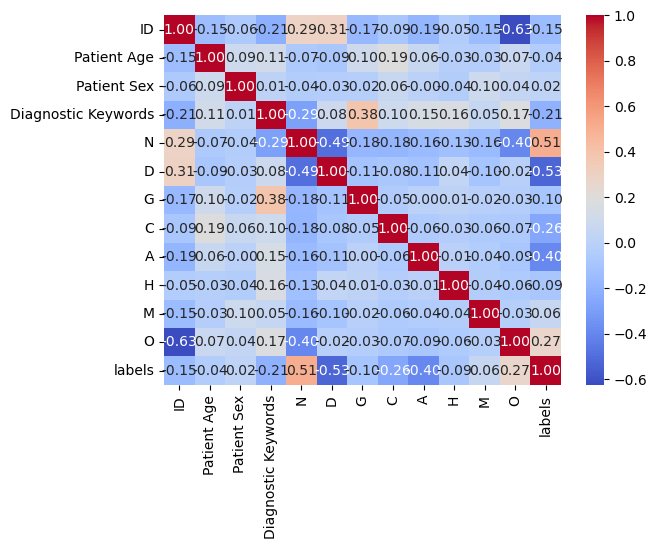

In [19]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

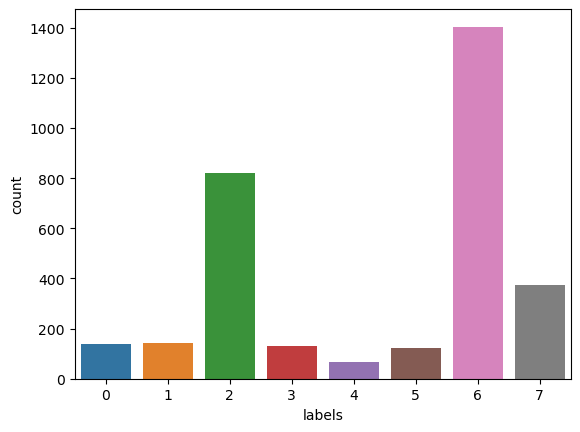

In [20]:
# labels is the target variable
sns.countplot(x='labels', data=df)
plt.show()

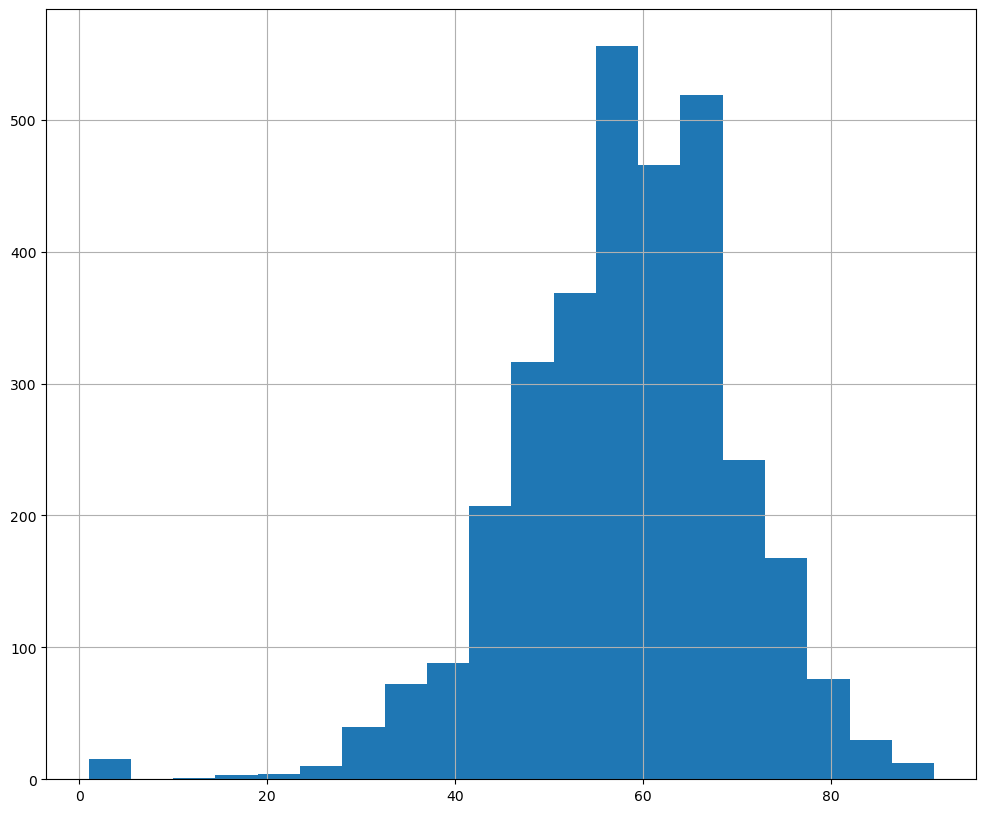

In [21]:
# patient age histogram
df['Patient Age'].hist(bins=20, figsize=(12, 10))
plt.show()

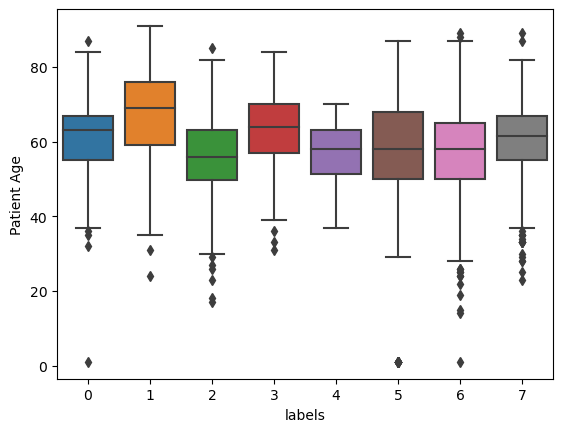

In [22]:
sns.boxplot(x='labels', y='Patient Age', data=df)
plt.show()

In [23]:
# spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# split_index = int(len(df) * 0.8)  # Adjust the percentage based on the training data size

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(
#     df.drop('labels', axis=1),  # Features
#     df['labels'],  # Target variable
#     test_size=None,  # Set test_size to None when shuffle is False
#     shuffle=False,  # Do not shuffle the data
#     train_size=split_index,  # Use the first part for training
#     random_state=42
# )

In [24]:
LR_model1 = LogisticRegression()
LR_model1.fit(X_train, y_train)

y_pred = LR_model1.predict(X_train)
precision = precision_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
acc = accuracy_score(y_train, y_pred)

print('RESULTS FOR THE LOGISTIC REGRESSION - TRAINING DATA')
print('-----------------------------------------------------')
print(f'Logistic Regression Model - training dataset, the precision is: {precision}')
print(f'Logistic Regression Model - training dataset, the f1-score is: {f1}')
print(f'Logistic Regression Model - training dataset, the recall is: {recall}')
print(f'Logistic Regression Model - training dataset, the accuracy is: {acc}\n')

y_pred = LR_model1.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

print('RESULTS FOR THE LOGISTIC REGRESSION - TESTING DATA')
print('-----------------------------------------------------')
print(f'Logistic Regression Model - testing dataset, the precision is: {precision}')
print(f'Logistic Regression Model - testing dataset, the f1-score is: {f1}')
print(f'Logistic Regression Model - testing dataset, the recall is: {recall}')
print(f'Logistic Regression Model - testing dataset, the accuracy is: {acc}\n')

RESULTS FOR THE LOGISTIC REGRESSION - TRAINING DATA
-----------------------------------------------------
Logistic Regression Model - training dataset, the precision is: 0.904022542097671
Logistic Regression Model - training dataset, the f1-score is: 0.8939159388899885
Logistic Regression Model - training dataset, the recall is: 0.8931506849315068
Logistic Regression Model - training dataset, the accuracy is: 0.8931506849315068

RESULTS FOR THE LOGISTIC REGRESSION - TESTING DATA
-----------------------------------------------------
Logistic Regression Model - testing dataset, the precision is: 0.9096027715484376
Logistic Regression Model - testing dataset, the f1-score is: 0.898570760947926
Logistic Regression Model - testing dataset, the recall is: 0.8967136150234741
Logistic Regression Model - testing dataset, the accuracy is: 0.8967136150234741



/Users/shivamthakur/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
KNN_model2 = KNeighborsClassifier()
KNN_model2.fit(X_train, y_train)

y_pred = KNN_model2.predict(X_train)
precision = precision_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
acc = accuracy_score(y_train, y_pred)

print('RESULTS FOR THE KNN - TRAINING DATA')
print('-----------------------------------------------------')
print(f'KNN Model - training dataset, the precision is: {precision}')
print(f'KNN Model - training dataset, the f1-score is: {f1}')
print(f'KNN Model - training dataset, the recall is: {recall}')
print(f'KNN Model - training dataset, the accuracy is: {acc}\n')

y_pred = KNN_model2.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)

print('RESULTS FOR THE KNN - TESTING DATA')
print('-----------------------------------------------------')
print(f'KNN Model - testing dataset, the precision is: {precision}')
print(f'KNN Model - testing dataset, the f1-score is: {f1}')
print(f'KNN Model - testing dataset, the recall is: {recall}')
print(f'KNN Model - testing dataset, the accuracy is: {acc}\n')

RESULTS FOR THE KNN - TRAINING DATA
-----------------------------------------------------
KNN Model - training dataset, the precision is: 0.9363831120642847
KNN Model - training dataset, the f1-score is: 0.9355575721836089
KNN Model - training dataset, the recall is: 0.9358121330724071
KNN Model - training dataset, the accuracy is: 0.9358121330724071

RESULTS FOR THE KNN - TESTING DATA
-----------------------------------------------------
KNN Model - testing dataset, the precision is: 0.919784482981987
KNN Model - testing dataset, the f1-score is: 0.9146137907938935
KNN Model - testing dataset, the recall is: 0.9154929577464789
KNN Model - testing dataset, the accuracy is: 0.9154929577464789



In [26]:
len(X_test)

639

In [27]:
# checking the predicted label and the actual label
# 1st value in the test data

y_pred = LR_model1.predict(X_test)
actual_label = y_test.iloc[1]

predicted_original_label = next(key for key, value in label_mapping.items() if value == y_pred[1])
actual_original_label = next(key for key, value in label_mapping.items() if value == actual_label)

# Output the original labels
print(f"Predicted Label: {predicted_original_label}")
print(f"Actual Label: {actual_original_label}")

Predicted Label: ['D']
Actual Label: ['N']


In [28]:
# checking the predicted label and the actual label
# 3rd value in the test data
  
y_pred = LR_model1.predict(X_test)
actual_label = y_test.iloc[3]

predicted_original_label = next(key for key, value in label_mapping.items() if value == y_pred[3])
actual_original_label = next(key for key, value in label_mapping.items() if value == actual_label)

# Output the original labels
print(f"Predicted Label: {predicted_original_label}")
print(f"Actual Label: {actual_original_label}")

Predicted Label: ['D']
Actual Label: ['D']


In [29]:
# checking the predicted label and the actual label
# 5th value in the test data

y_pred = LR_model1.predict(X_test)
actual_label = y_test.iloc[15]

predicted_original_label = next(key for key, value in label_mapping.items() if value == y_pred[15])
actual_original_label = next(key for key, value in label_mapping.items() if value == actual_label)

# Output the original labels
print(f"Predicted Label: {predicted_original_label}")
print(f"Actual Label: {actual_original_label}")

Predicted Label: ['D']
Actual Label: ['D']


In [30]:
img_df = pd.DataFrame(data)
img_df.head(5)

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [31]:
img_df = img_df[['Fundus','filename','labels']]
img_df.head(5)

,Fundus,filename,labels
0,0_right.jpg,0_right.jpg,['N']
1,1_right.jpg,1_right.jpg,['N']
2,2_right.jpg,2_right.jpg,['D']
3,4_right.jpg,4_right.jpg,['D']
4,5_right.jpg,5_right.jpg,['D']


In [32]:
# removed the filepath from the dataset since our path is different 
# below is the path for the images
filepath= '/Users/shivamthakur/Desktop/Python/Data Mining(Kaggle)/code/ODIR-5K/preprocessed_images/'

In [33]:
img_df['filepath']=filepath
img_df.head(5)

,Fundus,filename,labels,filepath
0,0_right.jpg,0_right.jpg,['N'],/Users/shivamthakur/Desktop/Python/Data Mining...
1,1_right.jpg,1_right.jpg,['N'],/Users/shivamthakur/Desktop/Python/Data Mining...
2,2_right.jpg,2_right.jpg,['D'],/Users/shivamthakur/Desktop/Python/Data Mining...
3,4_right.jpg,4_right.jpg,['D'],/Users/shivamthakur/Desktop/Python/Data Mining...
4,5_right.jpg,5_right.jpg,['D'],/Users/shivamthakur/Desktop/Python/Data Mining...


In [34]:
img_df['img_path']= img_df['filepath'] + img_df['filename']
img_df.head(5)

,Fundus,filename,labels,filepath,img_path
0,0_right.jpg,0_right.jpg,['N'],/Users/shivamthakur/Desktop/Python/Data Mining...,/Users/shivamthakur/Desktop/Python/Data Mining...
1,1_right.jpg,1_right.jpg,['N'],/Users/shivamthakur/Desktop/Python/Data Mining...,/Users/shivamthakur/Desktop/Python/Data Mining...
2,2_right.jpg,2_right.jpg,['D'],/Users/shivamthakur/Desktop/Python/Data Mining...,/Users/shivamthakur/Desktop/Python/Data Mining...
3,4_right.jpg,4_right.jpg,['D'],/Users/shivamthakur/Desktop/Python/Data Mining...,/Users/shivamthakur/Desktop/Python/Data Mining...
4,5_right.jpg,5_right.jpg,['D'],/Users/shivamthakur/Desktop/Python/Data Mining...,/Users/shivamthakur/Desktop/Python/Data Mining...


In [35]:
img_df = img_df[['img_path','labels']]
img_df.head(5)

,img_path,labels
0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N']
1,/Users/shivamthakur/Desktop/Python/Data Mining...,['N']
2,/Users/shivamthakur/Desktop/Python/Data Mining...,['D']
3,/Users/shivamthakur/Desktop/Python/Data Mining...,['D']
4,/Users/shivamthakur/Desktop/Python/Data Mining...,['D']


In [36]:
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    #img = img / 255.0  # Normalize pixel values to be between 0 and 1
    return img

img_df['images'] = img_df['img_path'].apply(load_and_preprocess_image)

img_df.head(5)

,img_path,labels,images
0,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,/Users/shivamthakur/Desktop/Python/Data Mining...,['N'],"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,/Users/shivamthakur/Desktop/Python/Data Mining...,['D'],"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


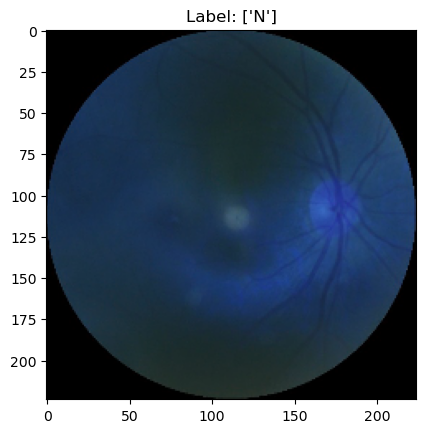

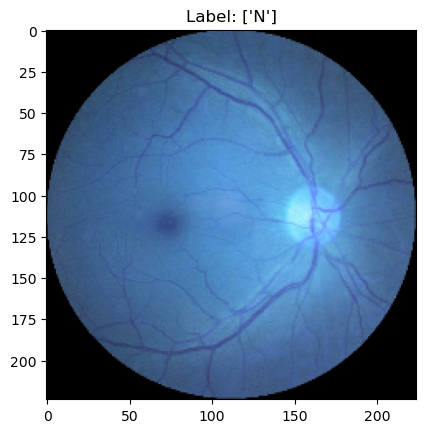

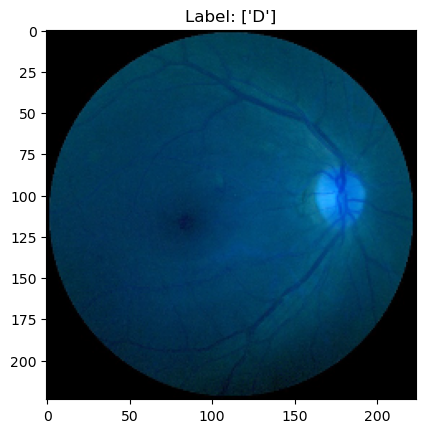

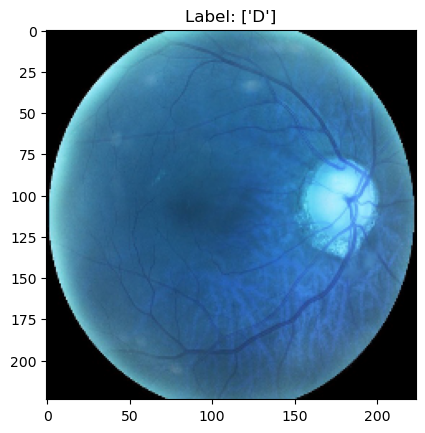

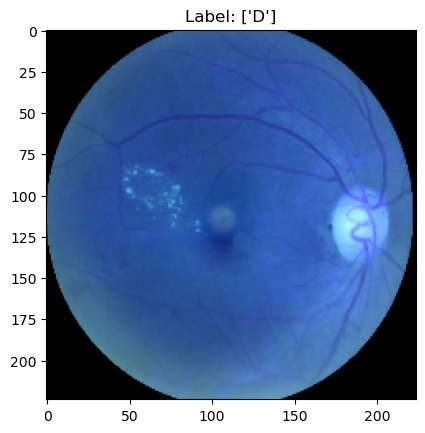

In [37]:
# Display the first 5 images
for i in range(5):
    plt.imshow(img_df['images'][i])
    plt.title(f"Label: {img_df['labels'][i]}")
    plt.show()


In [38]:
# the above dataframe is representing the images in a np array, for visualization, this is the images of the first 5 rows

In [39]:
def read_and_resize(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    return image

img_df['images'] = img_df['img_path'].apply(read_and_resize)

In [40]:
label_encoder = LabelEncoder()
img_df['encoded_labels'] = label_encoder.fit_transform(img_df['labels'])

In [41]:
train_df, test_df = train_test_split(img_df, test_size=0.2, random_state=42)

In [42]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 
# this is for image data generator

In [43]:
# Flow from dataframe with target size, class mode, and batch size
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="img_path",
    y_col="encoded_labels",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224)  # adjust target size as needed
)
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="img_path",
    y_col="encoded_labels",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(224, 224)  # adjust target size as needed
)

Found 2044 validated image filenames.
Found 511 validated image filenames.


In [44]:
# CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

In [45]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss',
                                   mode='min', verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=10,  # adjust the number of epochs
                    validation_data=valid_generator,
                    callbacks=[model_checkpoint])

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 1.6746 - accuracy: 0.4154
Epoch 1: val_loss improved from inf to 1.56123, saving model to best_model.h5
64/64 [==============================] - 50s 773ms/step - loss: 1.6746 - accuracy: 0.4154 - val_loss: 1.5612 - val_accuracy: 0.4149
Epoch 2/10


/Users/shivamthakur/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - ETA: 0s - loss: 1.5830 - accuracy: 0.4413
Epoch 2: val_loss did not improve from 1.56123
64/64 [==============================] - 63s 990ms/step - loss: 1.5830 - accuracy: 0.4413 - val_loss: 1.5688 - val_accuracy: 0.4149
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 1.5619 - accuracy: 0.4388
Epoch 3: val_loss improved from 1.56123 to 1.51545, saving model to best_model.h5
64/64 [==============================] - 69s 1s/step - loss: 1.5619 - accuracy: 0.4388 - val_loss: 1.5154 - val_accuracy: 0.4051
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 1.5118 - accuracy: 0.4428
Epoch 4: val_loss improved from 1.51545 to 1.46818, saving model to best_model.h5
64/64 [==============================] - 78s 1s/step - loss: 1.5118 - accuracy: 0.4428 - val_loss: 1.4682 - val_accuracy: 0.4344
Epoch 5/10
64/64 [==============================] - ETA: 0s - loss: 1.4685 - accuracy: 0.4530
Epoch 5: val_loss did not improve 

In [46]:
# eval test data

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="img_path",
    y_col="encoded_labels",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="raw",
    target_size=(224, 224)  # adjust target size as needed
)

# Load the best model weights
model.load_weights('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 639 validated image filenames.
20/20 [==============================] - 9s 434ms/step - loss: 1.4527 - accuracy: 0.4617
Test Accuracy: 46.17%


1/1 [==============================] - 0s 271ms/step
True Label: ['D']
Predicted Label: ['N']


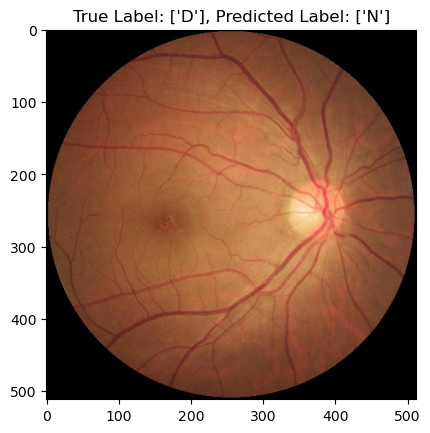

In [47]:
sample_data = test_df.sample(1)
sample_img_path = sample_data['img_path'].values[0]
sample_label = sample_data['encoded_labels'].values[0]

# Read and preprocess the image
sample_image = read_and_resize(sample_img_path)
sample_image = np.expand_dims(sample_image, axis=0) / 255.0

# Make prediction
prediction = model.predict(sample_image)
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

print(f"True Label: {label_encoder.inverse_transform([sample_label])[0]}")
print(f"Predicted Label: {predicted_label[0]}")

# Display the image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cv2.imread(sample_img_path), cv2.COLOR_BGR2RGB))
plt.title(f"True Label: {label_encoder.inverse_transform([sample_label])[0]}, Predicted Label: {predicted_label[0]}")
plt.show()